# Финальное задание по теме обработки изображений
В этом задании вы напишете класс Dataset для задачи сегментации. 

В папке Train_Data находятся изображения. В input — картинки с котиками, в mask — маски изображений. Критерий правильно написанного класса — у вас запустилось обучение.

Датасет небольшой, поэтому не удивляйтесь, что сегментация будет не очень точной, но отрисуйте пару сегментированных котиков. 

Для начала скачайте датасет и положите его на свой Google-диск. 

# Загрузка датасета

In [1]:
# from google.colab import drive 
# drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

Разархивируем наш датасет

In [2]:
# !unzip /content/gdrive/MyDrive/Train_Data.zip

Archive:  /content/gdrive/MyDrive/Train_Data.zip
   creating: Train_Data/
  inflating: __MACOSX/._Train_Data   
   creating: Train_Data/input/
  inflating: __MACOSX/Train_Data/._input  
   creating: Train_Data/mask/
  inflating: __MACOSX/Train_Data/._mask  
  inflating: Train_Data/input/cat.6.jpg  
  inflating: __MACOSX/Train_Data/input/._cat.6.jpg  
  inflating: Train_Data/input/cat.30.jpg  
  inflating: __MACOSX/Train_Data/input/._cat.30.jpg  
  inflating: Train_Data/input/cat.24.jpg  
  inflating: __MACOSX/Train_Data/input/._cat.24.jpg  
  inflating: Train_Data/input/cat.18.jpg  
  inflating: __MACOSX/Train_Data/input/._cat.18.jpg  
  inflating: Train_Data/input/cat.19.jpg  
  inflating: __MACOSX/Train_Data/input/._cat.19.jpg  
  inflating: Train_Data/input/cat.25.jpg  
  inflating: __MACOSX/Train_Data/input/._cat.25.jpg  
  inflating: Train_Data/input/cat.31.jpg  
  inflating: __MACOSX/Train_Data/input/._cat.31.jpg  
  inflating: Train_Data/input/cat.7.jpg  
  inflating: __MACOSX/T

Импортируем нужные библиотеки

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from sklearn.metrics import accuracy_score

Для решения задачи сегментации будем использовать известную архитектуру Unet.

# UNet архитектура

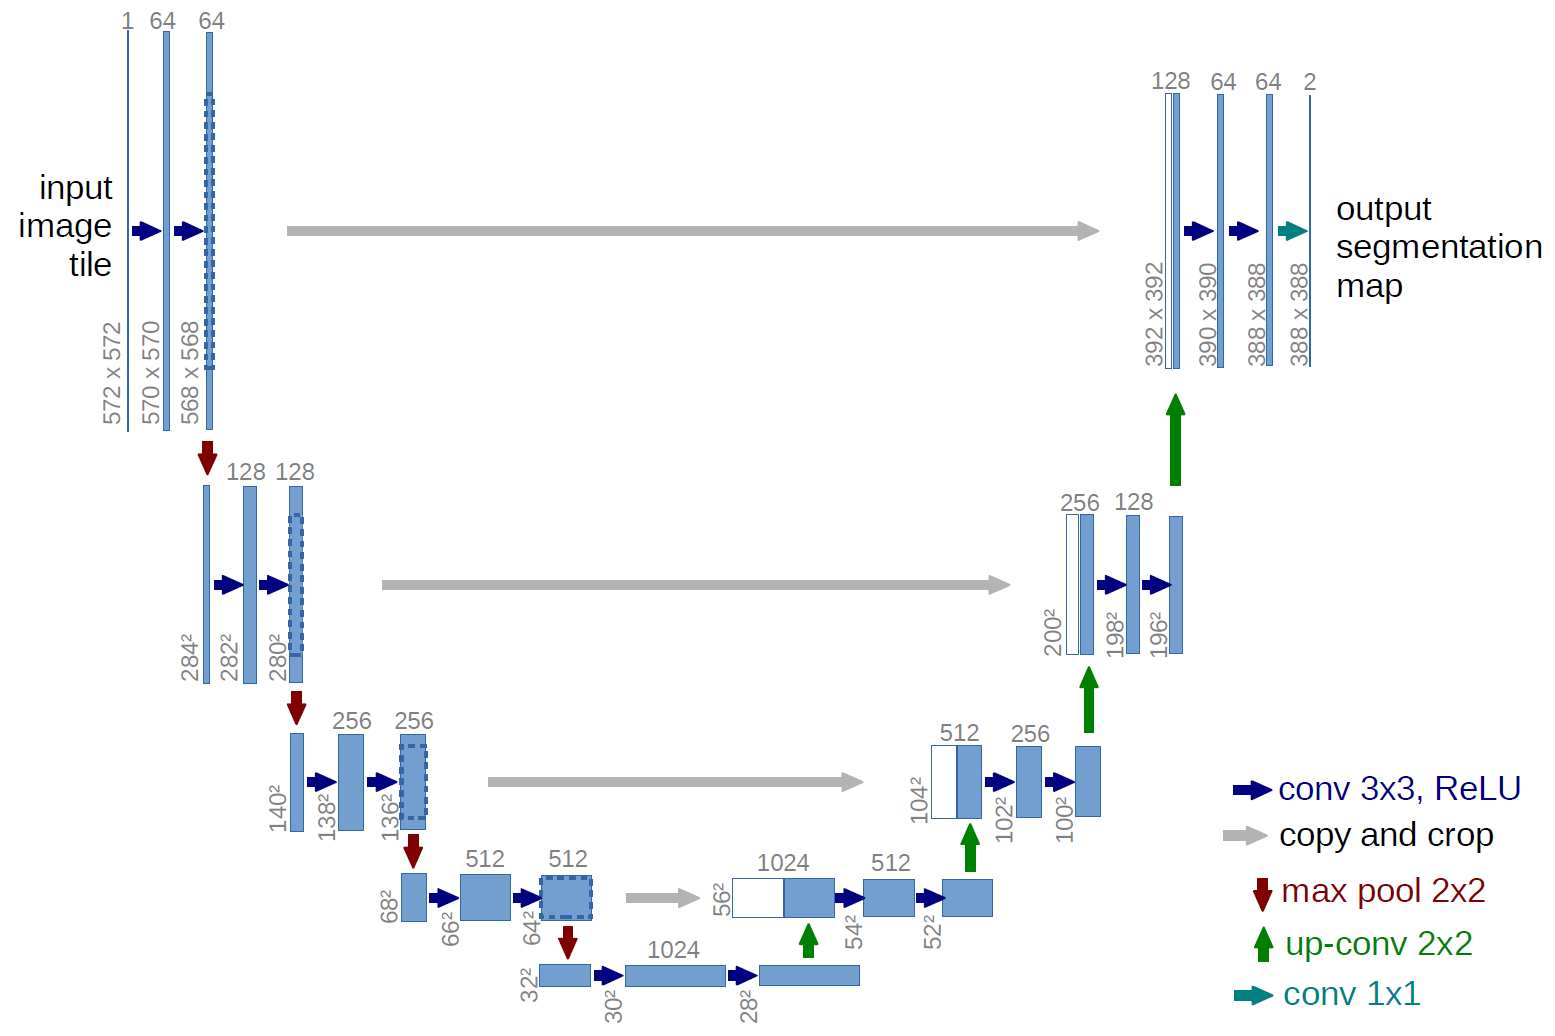

Архитектура UNet используется для сегментации картинок и представляет собой сверточную нейросеть.

Так выглядит архитектура UNet, реализованная в виде кода.

In [5]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Это была общая архитектура. Подробнее об ней вы можете прочитать [здесь](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

Теперь необходимо реализовать отдельные ее блоки.

DoubleConv — блок, состоящий из повторяющихся друг за другом послежовательностей конволюция -> нормализация по батчам -> активация ReLU.

In [6]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


Down — один шажок Downsampling, или понижения размерности. Состоит из пулинга и представленной выше двойной конволюции.

In [7]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

Up — обратная операция, повышение размерности.

In [8]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Класс Dataset

Реализуйте свой класс DataSet

In [87]:
test_transforms = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((256, 256)),
        transforms.ToTensor()
])

class my_dataset(torch.utils.data.Dataset):
    def __init__(self, path_to_images, path_to_masks, transforms):
        self.path_to_images = path_to_images
        self.images = os.listdir(path_to_images)
        self.path_to_masks = path_to_masks
        self.transforms = transforms


    def __len__(self):
        return len(self.images)


    def __getitem__ (self, idx):
        img_path = self.images[idx]
        data = Image.open(os.path.join(self.path_to_images, img_path))
        if self.transforms:
          data = self.transforms(data).type(torch.cuda.FloatTensor)
        target = Image.open(os.path.join(self.path_to_masks, f'mask_{img_path}'))
        if self.transforms:
          target = self.transforms(target).type(torch.cuda.FloatTensor)
        print(os.path.join(self.path_to_images, img_path), os.path.join(self.path_to_masks, f'mask_{img_path}'))
        return (data, target)
              
train_dataset = my_dataset('content/Train_Data/input', 'content/Train_Data/mask', transforms=test_transforms)
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

# Обучение модели

In [83]:
def compute_loss(y_pred, y_true):
    return -torch.mean(torch.sum(y_true*torch.log(F.softmax(y_pred,dim=0)),dim=0))

In [18]:
!nvidia-smi

Fri Jan 13 17:59:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   36C    P8    14W /  N/A |    370MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

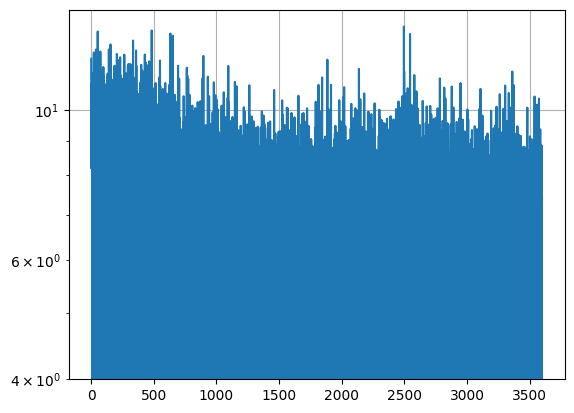

In [92]:
import time
from IPython.display import clear_output
model = UNet(n_channels=1,n_classes = 1);#UNet(n_class = 2);
model.cuda()
opt = torch.optim.Adam(model.parameters())

num_epochs = 400
train_loss = []

for i in range(num_epochs):
    start_time = time.time()
    model.train(True)
    for (X_batch, y_batch) in train_batch_gen:
        print(X_batch.size())
        loss = compute_loss(model(X_batch),y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        error = loss.item()
        train_loss.append(error)
        
        clear_output(True)
        plt.semilogy(train_loss)
        plt.grid()
        plt.show()

# Оценка результатов

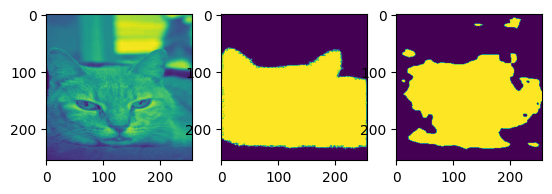

In [138]:
num = np.random.randint(80)
im = cv2.imread(f'content/Train_Data/input/cat.{num}.jpg')
d = cv2.resize(im.T[1,:,:], (256, 256))
d = d[None]
ms = cv2.imread(f'content/Train_Data/mask/mask_cat.{num}.jpg')
s = cv2.resize(ms.T[1,:,:], (256, 256))
s = s[None]
a = model.forward(torch.FloatTensor(d/255)[None].cuda())
b = a.detach()
c = b.cpu().numpy()
plt.subplot(131)
plt.imshow(d[0,:,:].T)
plt.subplot(132)
plt.imshow(s[0,:,:].T)
plt.subplot(133)
plt.imshow(c[0,:,:].squeeze(0).T>0.002)
plt.show()

In [96]:
train_loss

[11.907888412475586,
 8.196860313415527,
 9.498611450195312,
 10.932413101196289,
 8.839155197143555,
 10.162470817565918,
 9.41893196105957,
 10.68730354309082,
 -0.0,
 10.842437744140625,
 9.630810737609863,
 9.118980407714844,
 9.189863204956055,
 11.335253715515137,
 8.024663925170898,
 10.774165153503418,
 9.885843276977539,
 -0.0,
 8.992413520812988,
 9.239484786987305,
 8.512008666992188,
 12.163154602050781,
 9.704248428344727,
 9.950640678405762,
 9.816478729248047,
 9.582521438598633,
 -0.0,
 9.588963508605957,
 9.739618301391602,
 9.356392860412598,
 10.056032180786133,
 10.916483879089355,
 9.32493782043457,
 9.18805980682373,
 10.228515625,
 -0.0,
 7.463968276977539,
 10.443120956420898,
 12.28598403930664,
 9.57101821899414,
 9.788213729858398,
 9.774688720703125,
 10.494455337524414,
 9.114845275878906,
 -0.0,
 9.713570594787598,
 9.01936149597168,
 11.273883819580078,
 8.745025634765625,
 9.769453048706055,
 7.8625617027282715,
 9.816003799438477,
 13.066444396972656,
 